## Cox Process

A Cox process [1] is closely related to a Poisson process [2] commonly used to model event arrivals described by a certain rate $\lambda > 0$. A discrete random variable $X$ is Poisson distributed if the number of events or counts $k$, has the following form:

\begin{equation}
Poiss(k; \lambda) = Pr\{X=k\} = \frac{\lambda^{k}}{k!}\exp(-\lambda)
\end{equation}

Note that the mean of the Poisson RV is equal to its rate as well as its variance: $E[X] = VAR[X] = \lambda$. In addition, the rates are additive. If $X_i$ are iid Poisson random variables with rate $\lambda_i$, then

\begin{equation}
    S = \sum_{i=i}^{n} X_i \sim Poiss\bigg(\sum_{i=1}^{n} \lambda_i \bigg)
\end{equation}

A Poisson process is defined as random countable subset of a space $S$ such that for any disjoint subsets $A_1,...,A_n$ of $S$, the number of points in each subset $N(A_1),...,N(A_n)$ are independent random variables that are Poisson distributed: $N(A_k) \sim Poiss(\mu(A_k))$, where the rate is defined by a mean measure $\mu(A)$ often expressed in terms of the rate function $\lambda(x): S \rightarrow \mathbb{R}^{+}$:

\begin{equation}
    \mu(A) = \int_A \lambda(x) dx < \infty
\end{equation}

If the rate function $\lambda(x)$ is constant, we have a *homogeneous* Poisson process, where $\mu(A) = \lambda |A|$, and $|A|$ denotes the measure of $A$, e.g. area in $\mathbb{R}^{2}$. If the rate function is spatially varying, then we have an *inhomogeneous* Poisson process [2].

A Cox Process is a Poisson process in which the rate function is itself a stochastic process [1]. In particular, a Log Gaussian Cox Process (LGCP) models the rate function $\lambda(x)$ as a transformation of a Gaussian Process (GP) [3] that guarantees positivity. Common transformations include exponential, sigmoid and square functions. We can summarize the Cox Process as follows:

\begin{eqnarray}
    f(x) &\sim& GP\big(m(x), K(x,x^{\prime})\big) \\
    \lambda(x) &=& \exp\{f(x)\} \\
    y(A) &\sim& Poiss\bigg(\int_A \lambda(x) dx \bigg)
\end{eqnarray}

Let's implement the Cox Process in PyMC! We'll use the redwoods dataset which is provided as part of spatstat R package. It contains locations of California redwood trees in a square sampling region.

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

import theano
import theano.tensor as tt

import warnings
warnings.filterwarnings('ignore')

In [8]:
#load data
print "loading data..."
train_df = pd.read_csv('./data/redwoods.csv')
train_df.head()


loading data...


,redwoodfull.x,redwoodfull.y
0,0.931481,0.817680
1,0.938889,0.764273
2,0.935185,0.721915
3,0.979630,0.664825
4,0.787037,0.661142


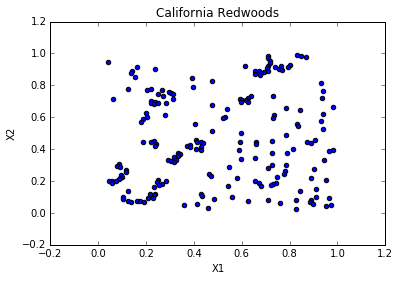

In [9]:
plt.figure()
plt.scatter(train_df['redwoodfull.x'], train_df['redwoodfull.y'])
plt.title('California Redwoods')
plt.xlabel('X1')
plt.ylabel('X2')
plt.savefig('./figures/redwoods_dataset.png')

In [10]:
#discretize spatial data
D = 2 #dimension
num_bins = 64
hist, xedges, yedges = np.histogram2d(train_df['redwoodfull.x'].values, train_df['redwoodfull.y'].values, bins=num_bins)
xcenters = xedges[:-1] + 0.5 * (xedges[1:] - xedges[:-1])
ycenters = yedges[:-1] + 0.5 * (yedges[1:] - yedges[:-1])

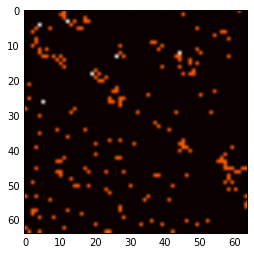

In [11]:
plt.figure()
plt.imshow(hist, cmap='hot')
plt.savefig('./figures/redwoods_hist.png')

In [12]:
#form input arrays
y_data = np.zeros(num_bins * num_bins)  #observations (counts)
x_data = np.zeros((num_bins * num_bins, 2)) #locations

cnt = 0
for i in range(num_bins):
    for j in range(num_bins):
        y_data[cnt] = hist[i][j]
        x_data[cnt,:] = np.hstack((xcenters[i], ycenters[j]))
        cnt += 1
    #end for
#end for

In [15]:
print "creating the model..."
with pm.Model() as model:
   
    #hyper-parameter priors
    #l = pm.Gamma('l', alpha=2, beta=2)   
    #eta = pm.HalfCauchy('eta', beta=3)
    #cov_func = eta**2 * pm.gp.cov.ExpQuad(D, ls=l*np.ones(D))

    #Gaussian Process
    cov_func = pm.gp.cov.ExpQuad(D, ls=0.1*np.ones(D))
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior('f', X=x_data)

    obs = pm.Poisson('obs', mu=tt.exp(f), observed=y_data)

creating the model...


In [16]:
print "model inference..."
with model:
    trace = pm.sample(1000, burn=500, thin=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


model inference...


100%|██████████| 1500/1500 [64:46:58<00:00, 155.48s/it]   


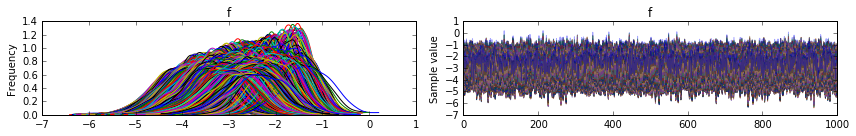

In [18]:
#generate plots
plt.figure()
pm.traceplot(trace, varnames=['f'])
plt.savefig('./figures/redwoods_trace.png')

In [19]:
ftrace = np.mean(trace['f'][500::2,:], axis=0)
ftrace = np.reshape(ftrace, (num_bins, num_bins))
latent_rate = np.exp(ftrace)

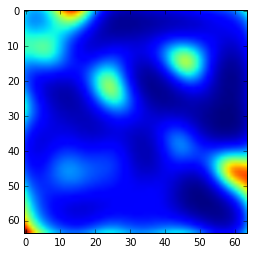

In [20]:
plt.figure()
plt.imshow(latent_rate)
plt.savefig('./figures/redwoods_latent_rate.png')


We can see that the heatmap of the latent rate function above matches the histogram plot, i.e. we can see higher concentration of trees along the main diagonal as well as patches above and below the diagonal. The latent rate function can give insight into land features that cause high tree growth.

### References

[1] D. Cox, "Some statistical methods connected with series of events", JRSS, 1955  
[2] J. Kingman, "Poisson Processes", Oxford Studies in Probability, Clarendon Press, 1993  
[3] C. Rasmussen and C. Williams, "Guassian Processes for Machine Learning", The MIT Press, 2006  